In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root
# root = here(project_files=[".here"])
local = here(project_files=[".local"])

# append to path
# sys.path.append(str(root))
sys.path.append(str(local))

%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tqdm.notebook import tqdm, trange
from kernellib.types import GeoData, Dimensions
from kernellib.kernels import SpatioTemporalKernel
from kernellib.preprocessing import create_oi_grid
from sklearn.kernel_ridge import KernelRidge

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# OI Grid
lon_min = 295.                                           # domain min longitude
lon_max = 305.                                           # domain max longitude
lat_min = 33.                                            # domain min latitude
lat_max = 43.                                            # domain max latitude
time_min = np.datetime64('2017-01-01')                # domain min time
time_max = np.datetime64('2017-03-31') #np.datetime64('2017-12-31')                # domain max time
dx = 0.1                                               # zonal grid spatial step (in degree)
dy = 0.1                                                 # meridional grid spatial step (in degree)
dt = np.timedelta64(1, 'D')                           # temporal grid step

glon = np.arange(lon_min, lon_max + dx, dx)           # output OI longitude grid
glat = np.arange(lat_min, lat_max + dy, dy)           # output OI latitude grid
gtime = np.arange(time_min, time_max + dt, dt)        # output OI time grid

In [4]:
glon.shape, glat.shape, gtime.shape

((102,), (102,), (90,))

### OI Params

In [5]:
# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 7.                                                  # Temporal decorrelation scale (in days)
noise = 0.05

## OI Grid

In [10]:
ds_oi_grid = create_oi_grid(glon, glat, gtime)
ds_oi_grid

<xarray.Dataset>
Dimensions:       (time: 90, lat: 102, lon: 102, samples: 10, ng: 10404, gtime: 90)
Coordinates:
  * gtime         (gtime) float64 0.0 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0
  * time          (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-03-31
  * lat           (lat) float64 33.0 33.1 33.2 33.3 33.4 ... 42.8 42.9 43.0 43.1
  * lon           (lon) float64 295.0 295.1 295.2 295.3 ... 304.9 305.0 305.1
  * samples       (samples) int64 0 1 2 3 4 5 6 7 8 9
  * ng            (ng) int64 0 1 2 3 4 5 ... 10398 10399 10400 10401 10402 10403
Data variables:
    gssh_mu       (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    gssh_var      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    gssh_samples  (samples, time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    glon2         (lat, lon) float64 295.0 295.1 295.2 ... 304.9 305.0 305.1
    glat2         (lat, lon) float64 33.0 33.0 33.0 33.0 ... 43.1 43.1 43.1 43.1
    fglon         (ng) float64 295.0 295.1 295.2 295.3 ... 304.9 305.0 305.1
    fglat         (ng) float64 33.0 33.0 33.0 33.0 33.0 ... 43.1 43.1 43.1 43.1
    nobs          (time) float64 -2.682e+154 -2.682e+154 ... -3.201e-86

## Observations

In [7]:
from kernellib.data import load_data

In [9]:
file_path = "/Volumes/EMANS_HDD/data/2021a_ose"
inputs = load_data(file_path)
inputs

['/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc',
 '/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc',
 '/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc',
 '/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc',
 '/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc',
 '/Volumes/EMANS_HDD/data/2021a_ose/dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc']

### Convert to Grid

In [40]:
def create_sla_grid(gdata, glon, glat, gtime):
    """
    
    """
    

    nx = len(glon)
    ny = len(glat)
    nt = len(gtime)

    # define & initialize ssh array
    gssh_mu = np.empty((nt, ny, nx))
    gssh_var = np.empty((nt, ny, nx))
    nobs = np.empty(nt)

    # Make 2D grid
    glon2, glat2 = np.meshgrid(glon, glat)
    fglon = glon2.flatten()
    fglat = glat2.flatten()

    ng = len(fglat) # number of grid points
    vtime = (gtime - gtime[0]) / np.timedelta64(1, 'D')
    
    
    ds_oi_grid = xr.Dataset({'gssh_mu' : (('time', 'lat', 'lon'), gssh_mu), 
                             'gssh_var' : (('time', 'lat', 'lon'), gssh_var),
                             'glon2' : (('lat', 'lon'), glon2),
                             'glat2' : (('lat', 'lon'), glat2),
                             'fglon' : (('ng'), fglon),
                             'fglat' : (('ng'), fglat),
                             'nobs' : (('time'), nobs)},
                              coords={'gtime': (vtime).astype(np.float),
                                      'time': gtime,
                                      'lat': glat, 
                                      'lon': glon,
                                      'ng': np.arange(ng)})

    return ds_oi_grid

In [11]:
ds = xr.open_mfdataset(inputs, , combine='nested', concat_dim='time', parallel=True, preprocess=preprocess)
ds

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [42]:
central_date = np.datetime64('2017-01-15')
delta_t = np.timedelta64(5, 'D')

In [13]:
coarsening = {'time': 5}

In [14]:
def preprocess(ds):
    return ds.coarsen(coarsening, boundary="trim").mean()

ds_obs = xr.open_mfdataset([inputs[0]], combine='nested', concat_dim='time', parallel=True, preprocess=preprocess) #.sortby('time')
#ds_obs = ds_obs.coarsen(coarsening, boundary="trim").mean().sortby('time')
ds_obs = ds_obs.sortby('time')

In [15]:
ds_obs

<xarray.Dataset>
Dimensions:         (time: 80816)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T08:49:11.845021952 ... 2...
    longitude       (time) float64 dask.array<chunksize=(80816,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(80816,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(80816,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(80816,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(80816,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(80816,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(80816,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(80816,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(80816,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(80816,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [45]:
# correct lon if domain is between [-180:180]
if lon_min < 0:
    ds_obs['longitude'] = xr.where(ds_obs['longitude'] >= 180., ds_obs['longitude']-360., ds_obs['longitude'])

In [46]:
# get maximum coordinate values
lon_min = ds_oi_grid.lon.min().values
lon_max = ds_oi_grid.lon.max().values
lat_min = ds_oi_grid.lat.min().values
lat_max = ds_oi_grid.lat.max().values
time_min = ds_oi_grid.time.min().values
time_max = ds_oi_grid.time.max().values

    

In [47]:
# subset time
ds_obs_subset = ds_obs.sel(time=slice(time_min - np.timedelta64(int(2*Lt), 'D'), 
                               time_max + np.timedelta64(int(2*Lt), 'D')), drop=True)

In [48]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 102795)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-18T00:30:53.055458764 ... 2...
    longitude       (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [49]:
# subset lat/lon values
ds_obs_subset = ds_obs_subset.where(
    (ds_obs_subset['longitude'] >= lon_min - Lx) & 
    (ds_obs_subset['longitude'] <= lon_max + Lx) &
    (ds_obs_subset['latitude'] >= lat_min - Ly) &
    (ds_obs_subset['latitude'] <= lat_max + Ly),
    drop=True
)

In [50]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 21010)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-18T01:11:31.083212748 ... 2...
    longitude       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [51]:
def add_vtime(ds, time_min: np.datetime64):
    vtime = (ds['time'].values - time_min) / np.timedelta64(1, 'D')
    return ds.assign_coords({'time': vtime})

In [52]:
type(time_min)

numpy.datetime64

In [53]:
time_min = np.datetime64('2017-01-01')
ds_obs_subset = add_vtime(ds_obs_subset, time_min)

In [54]:
# # add vtime coord
# vtime = (ds_obs_subset['time'].values - time_min) / np.timedelta64(1, 'D')
# ds_obs_subset = ds_obs_subset.assign_coords({'time': vtime})



In [55]:
ds_obs_subset = ds_obs_subset.dropna(dim='time')

In [56]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 21010)
Coordinates:
  * time            (time) float64 -13.95 -13.81 -13.65 ... 102.9 102.9 102.9
    longitude       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## OI Algorithm

$$
\mathbf{y} = \mathbf{Hx} + \boldsymbol{\epsilon}
$$

where:

* $\mathbf{x} \in \mathbb{R}^{D_\mathbf{x}}$ - the unknown state to be estimated
* $\mathbf{y} \in \mathbb{R}^{D_\mathbf{y}}$ - the observations
* $\mathbf{H} \in \mathbb{R}^{D_\mathbf{y} \times D_\mathbf{x}}$ - the linear observation operator
* $\boldsymbol{\epsilon} \in \mathbb{R}^{D_\mathbf{y}}$ - the independent observation error

---

$$
\mathbf{x} = \mathbf{Ky}
$$

where:

* $\mathbf{K} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{y}}$ - Kalman Gain

$$
\mathbf{K} = \mathbf{BH}^\top \left( \mathbf{HBH}^\top\right)^{-1}
$$

where:

* $\mathbf{B} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{x}}$ - covariance of $\mathbf{x}$


### Example I - Single Region

In [57]:
# example time step
i_time = 30

In [107]:
# get indices where there are observations
ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 10. * Lt))[0]

ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 0.5))[0]
n_obs = len(ind1)


# get observation data
obs_data = GeoData(
    lat=ds_obs_subset.latitude.values[ind1],
    lon=ds_obs_subset.longitude.values[ind1],
    time=ds_obs_subset.time.values[ind1],
    data=ds_obs_subset.sla_unfiltered.values[ind1]
)

obs_data_t = GeoData(
    lat=ds_obs_subset.latitude.values[ind_t],
    lon=ds_obs_subset.longitude.values[ind_t],
    time=ds_obs_subset.time.values[ind_t],
    data=ds_obs_subset.sla_unfiltered.values[ind_t]
)

# get state data
state_data = Dimensions(
    lat=ds_oi_grid.fglat.values,
    lon=ds_oi_grid.fglon.values,
    time=ds_oi_grid.gtime.values[i_time]
)


state_coords = state_data.coord_vector()
obs_coords = obs_data.coord_vector()

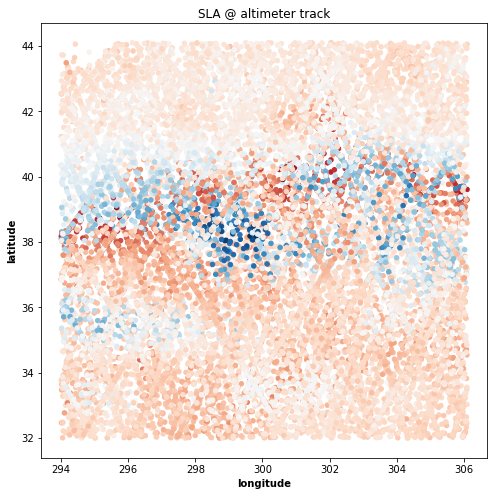

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data.lon, obs_data.lat, c=obs_data.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

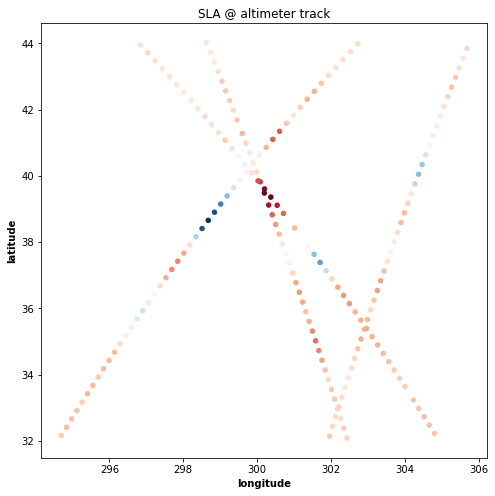

In [109]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

In [110]:
print(state_coords.shape, obs_coords.shape)

(10404, 3) (20528, 3)


#### Data Kernel Matrix


$$
\boldsymbol{k}([\mathbf{x},t], [\mathbf{x}', t']) = \boldsymbol{k}(\mathbf{x},\mathbf{x}') * \boldsymbol{k}(t, t')
$$

where: $\mathbf{x} = \text{lat, lon}$


$$
\boldsymbol{k}(\mathbf{x},\mathbf{x}') = \exp (-\frac{1}{\sigma^2} ||\mathbf{x} - \mathbf{x}'||_2^2)
$$

In [111]:
import gpytorch

In [130]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, RFFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import SmoothedBoxPrior

# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims=3))
#         self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:500, :], likelihood=likelihood)

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)
    
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-1e-5, 1e-5))
        self.covar_module = ScaleKernel(RFFKernel(num_samples=100))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [131]:
import torch

In [132]:
train_x = torch.Tensor(obs_coords)
train_y = torch.Tensor(obs_data.data)

In [133]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)


In [134]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [135]:
training_iterations = 100

In [136]:
%time

with trange(training_iterations) as pbar:
    
    for i in pbar:
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        pbar.set_description('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [119]:
test_x = torch.Tensor(state_coords)

In [120]:
test_x.shape

torch.Size([10404, 3])

In [121]:
model.eval()
likelihood.eval()
n_batches = 100
y_mus, y_stds = [], []
for X_batch in tqdm(zip(np.array_split(state_coords, n_batches))):
    
    with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
        preds = model(torch.Tensor(X_batch))
        
        y_mus.append(preds.mean.detach().squeeze())
        y_stds.append(preds.variance.sqrt().detach().squeeze())


0it [00:00, ?it/s]

In [122]:
y_mu = torch.cat(y_mus).numpy()
y_std = torch.cat(y_stds).numpy()

In [123]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    preds = model(test_x)

In [124]:
y_mu = preds.mean.detach().numpy()
y_std = preds.variance.sqrt().detach().numpy()

In [125]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

In [126]:
y_mu.min(), y_mu.max()

(0.0035320148, 0.083694816)

In [127]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-3.2537], requires_grad=True)),
 ('mean_module.constant',
  Parameter containing:
  tensor([0.0319], requires_grad=True)),
 ('base_covar_module.raw_outputscale',
  Parameter containing:
  tensor(-5.8427, requires_grad=True)),
 ('base_covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[11.2157,  0.5371,  1.3355]], requires_grad=True)),
 ('covar_module.inducing_points',
  Parameter containing:
  tensor([[-10.8061,  40.2615, 304.3271],
          [-12.6142,  38.9313, 304.0325],
          [ -9.9744,  33.0450, 298.9040],
          ...,
          [ -9.9917,  36.7472, 297.0450],
          [ -6.2671,  38.4226, 297.8003],
          [ -4.3960,  39.0260, 299.7291]], requires_grad=True))]

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_86662/2193579209.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_86662/2193579209.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


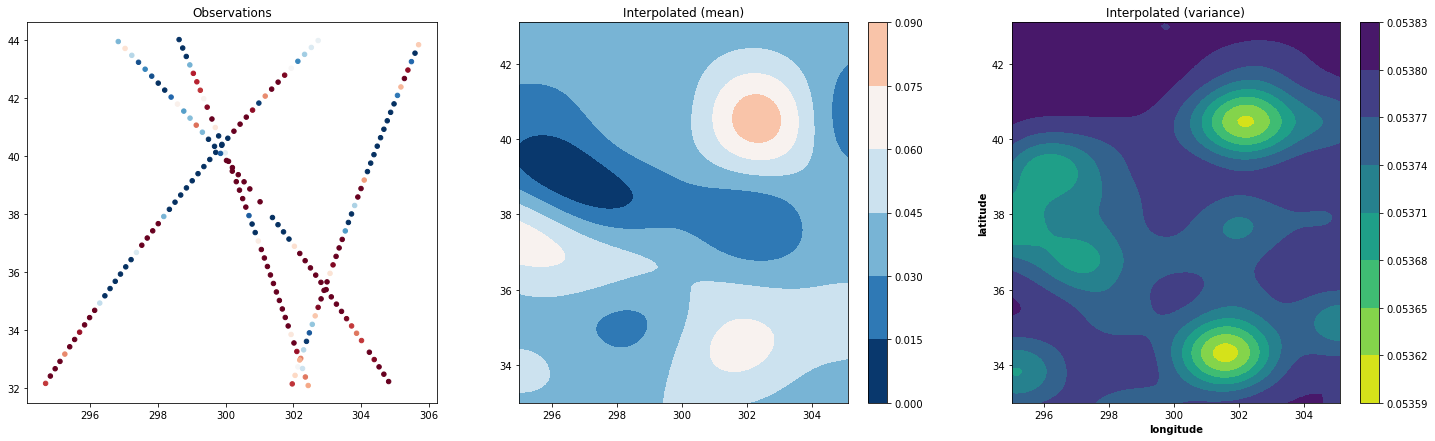

In [128]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_86662/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_86662/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


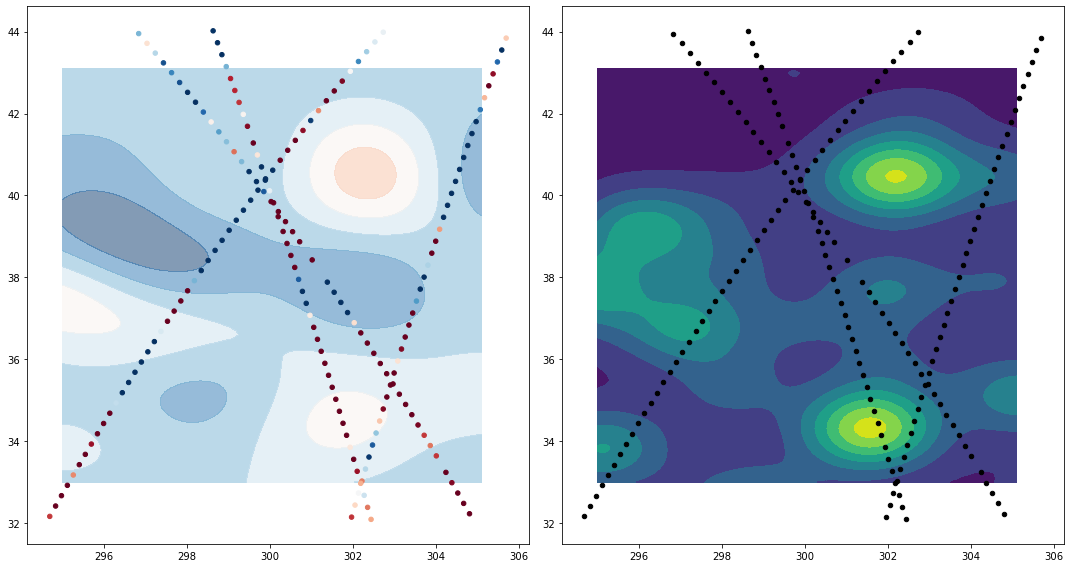

In [129]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

In [102]:
with torch.no_grad():
    y_samples = preds.rsample(sample_shape=torch.Size((100,)))
    
y_samples = y_samples.detach().numpy()

In [100]:
y_samples.shape

torch.Size([100, 2652])

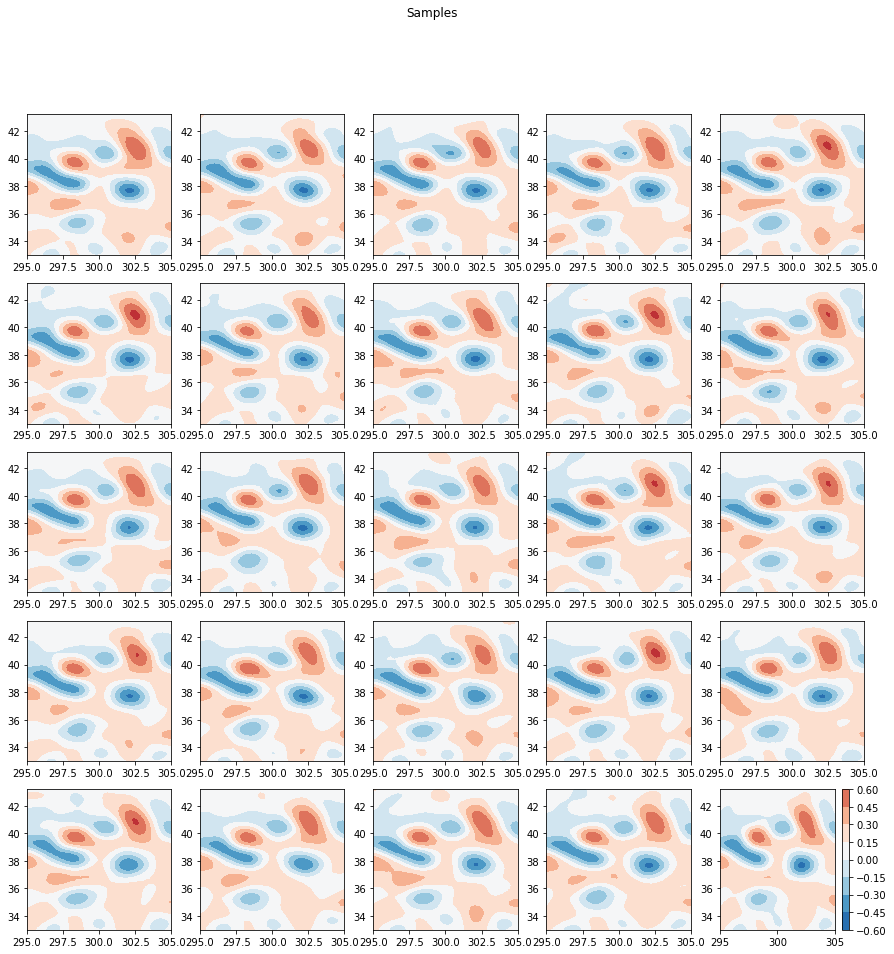

In [104]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    img = iax.tricontourf(state_data.lon, state_data.lat, y_samples[i, :].squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.colorbar(img)
plt.show()




In [106]:
y_mu = y_samples.mean(0)

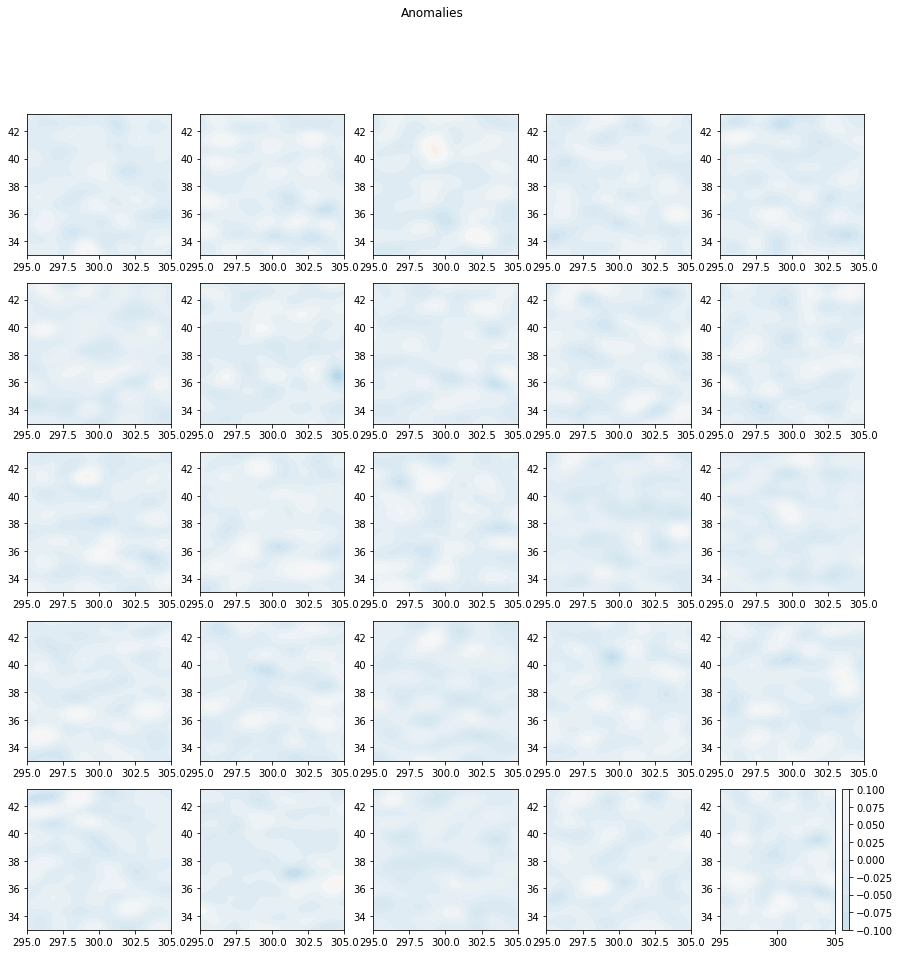

In [108]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    # anomalies
    anomaly = y_mu.squeeze() - y_samples[i].squeeze()
    img = iax.tricontourf(state_data.lon, state_data.lat, anomaly.squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Anomalies")
plt.colorbar(img)
plt.show()

In [34]:
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import SpatioTemporalKernel

# spatial kernel
length_scale = Lx
length_scale_bounds = (1e-5, 1e5)

spatial_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)


# temporal kernel
length_scale = Lt
length_scale_bounds = (1e-5, 1e5)

temporal_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)

kernel = SpatioTemporalKernel(spatial_kernel, temporal_kernel)

In [35]:
K = kernel(obs_coords)

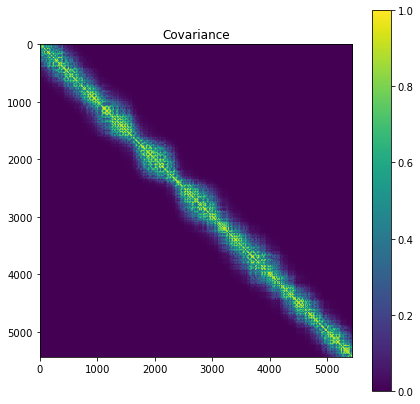

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))

img = ax.imshow(K, cmap="viridis")
ax.set(title="Covariance")
plt.colorbar(img)
plt.show()

### Spatial Kernel

In [37]:

# spatial kernel
length_scale = Lx
length_scale_bounds = (1e-5, 1e5)

spatial_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)

K_spatial = spatial_kernel(obs_coords[:, 1:])

vmin = K_spatial.min()
vmax = K_spatial.max()

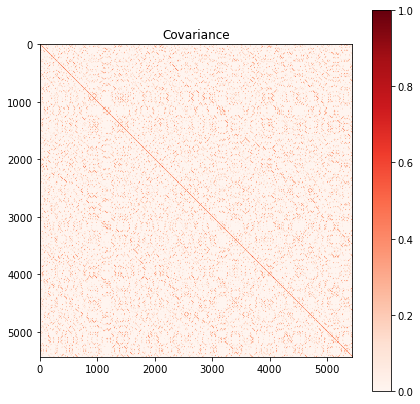

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))

img = ax.imshow(K_spatial, cmap="Reds")
ax.set(title="Covariance")
plt.colorbar(img)
plt.show()

In [39]:
from sklearn.kernel_approximation import RBFSampler

In [40]:
K_spatial_approx = {}

for i in [10, 100, 1_000]:
    
    rff_kernel_spatial = RBFSampler(gamma=1/Lx**2, n_components=i)
    
    Z_spatial_approx = rff_kernel_spatial.fit_transform(obs_coords[:, 1:])
    

    K_spatial_approx[f"{i}"] = Z_spatial_approx @ Z_spatial_approx.T
    
    vmin = np.minimum(vmin, K_spatial_approx[f"{i}"].min())
    vmax = np.maximum(vmax, K_spatial_approx[f"{i}"].max())

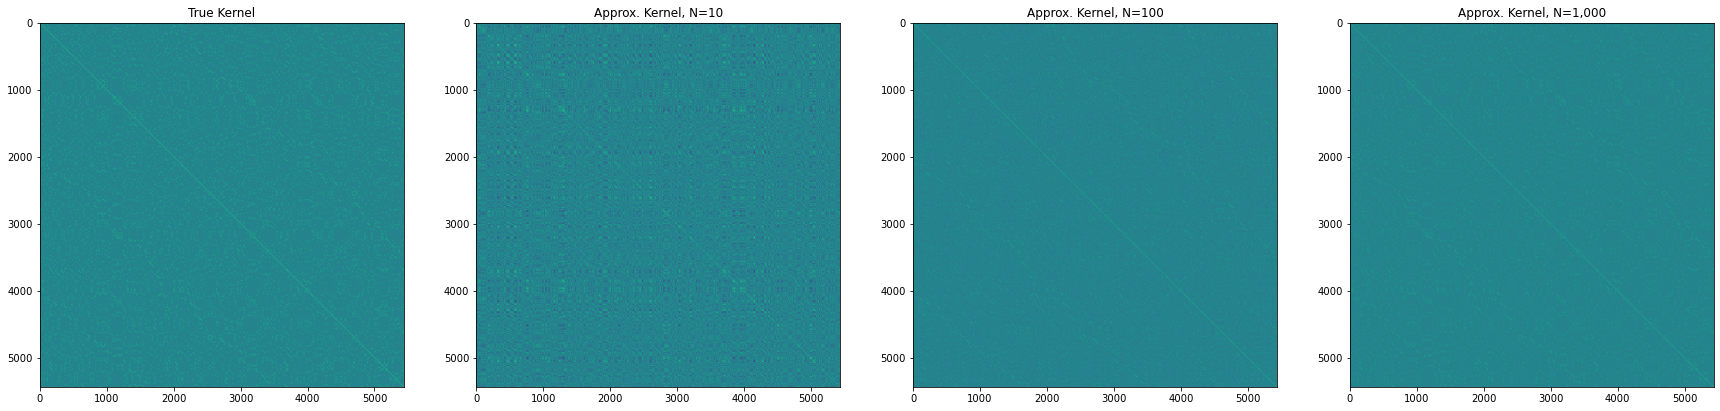

In [41]:
fig, ax = plt.subplots(figsize=(30, 10), ncols=4)

# True Kernel
ax[0].imshow(K_spatial, cmap="viridis", aspect="equal", vmin=vmin, vmax=vmax)
ax[0].set(title="True Kernel")

ax[1].imshow(K_spatial_approx["10"], cmap="viridis", aspect="equal", vmin=vmin, vmax=vmax)
ax[1].set(title=f"Approx. Kernel, N={10}")

ax[2].imshow(K_spatial_approx["100"], cmap="viridis", aspect="equal", vmin=vmin, vmax=vmax)
ax[2].set(title=f"Approx. Kernel, N=100")

ax[3].imshow(K_spatial_approx["1000"], cmap="viridis", aspect="equal", vmin=vmin, vmax=vmax)
ax[3].set(title=f"Approx. Kernel, N=1,000")

plt.show()

### Temporal Kernel

In [42]:

# temporal kernel
length_scale = Lt
length_scale_bounds = (1e-5, 1e5)

temporal_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)

Kt = temporal_kernel(obs_coords[:, 0][:, None])

vmin = Kt.min()
vmax = Kt.max()

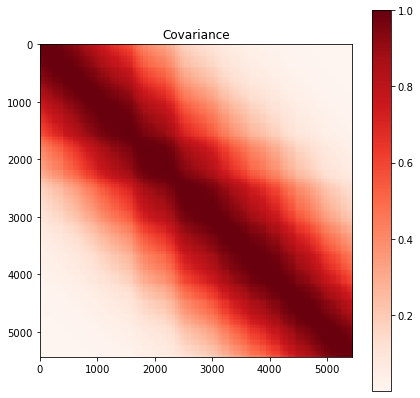

In [43]:
fig, ax = plt.subplots(figsize=(7, 7))

img = ax.imshow(Kt, cmap="Reds")
ax.set(title="Covariance")
plt.colorbar(img)
plt.show()

In [44]:
Kt_approx = {}

for i in [10, 100, 1_000]:
    
    
    Zt_approx = RBFSampler(gamma=1/Lt**2, n_components=i).fit_transform(obs_coords[:, 0][:, None])
    

    Kt_approx[f"{i}"] = Zt_approx @ Zt_approx.T
    
    vmin = np.minimum(vmin, Kt_approx[f"{i}"].min())
    vmax = np.maximum(vmax, Kt_approx[f"{i}"].max())

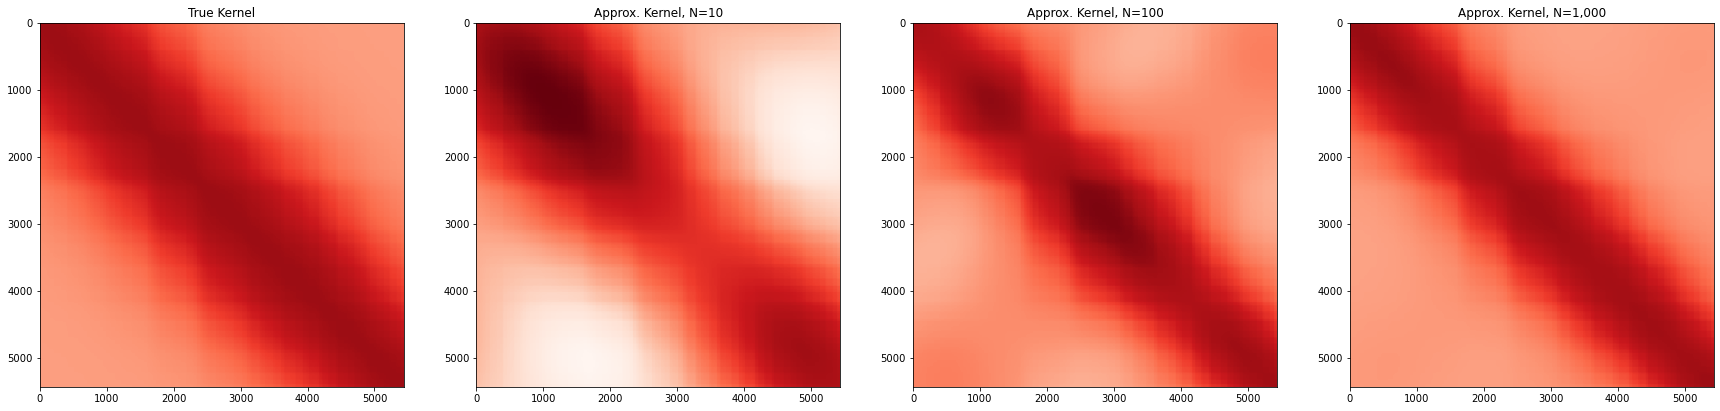

In [45]:
fig, ax = plt.subplots(figsize=(30, 10), ncols=4)

# True Kernel
ax[0].imshow(Kt, cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[0].set(title="True Kernel")

ax[1].imshow(Kt_approx["10"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[1].set(title=f"Approx. Kernel, N={10}")

ax[2].imshow(Kt_approx["100"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[2].set(title=f"Approx. Kernel, N=100")

ax[3].imshow(Kt_approx["1000"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[3].set(title=f"Approx. Kernel, N=1,000")

plt.show()

### Spatio-Temporal Kernel

In [46]:
# spatial kernel
length_scale = Lx
length_scale_bounds = (1e-5, 1e5)

spatial_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)


# temporal kernel
length_scale = Lt
length_scale_bounds = (1e-5, 1e5)

temporal_kernel = RBF(
    length_scale=length_scale, 
    length_scale_bounds=length_scale_bounds
)

kernel = SpatioTemporalKernel(spatial_kernel, temporal_kernel)

K = kernel(obs_coords)

vmin = K.min()
vmax = K.max()

# length_scale = np.array([Lt, Lx, Ly])
# kernel = RBF(
#     length_scale=Lx, 
#     length_scale_bounds=length_scale_bounds
# )

# K = kernel(obs_coords)

# vmin = K.min()
# vmax = K.max()

In [47]:
Lt, Lx

(7.0, 1.0)

In [48]:
%time

K_approx = {}

for i in [10, 100, 1_000]:
    
    Zt_approx = RBFSampler(gamma=Lt**2, n_components=i).fit_transform(obs_coords[:, 0][:, None])
    Zx_approx = RBFSampler(gamma=Lx**2, n_components=i).fit_transform(obs_coords[:, 1:])
    
    K_approx[f"{i}"] = (Zx_approx @ Zx_approx.T) * (Zt_approx @ Zt_approx.T)
    # Zx_approx = RBFSampler(gamma=1/Lx**2, n_components=i).fit_transform(obs_coords[:, 1:])
    
    
    # K_approx[f"{i}"] = (Zx_approx @ Zx_approx.T) * (Zt_approx @ Zt_approx.T)
    

    
    vmin = np.minimum(vmin, K_approx[f"{i}"].min())
    vmax = np.maximum(vmax, K_approx[f"{i}"].max())
    

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 3.81 µs


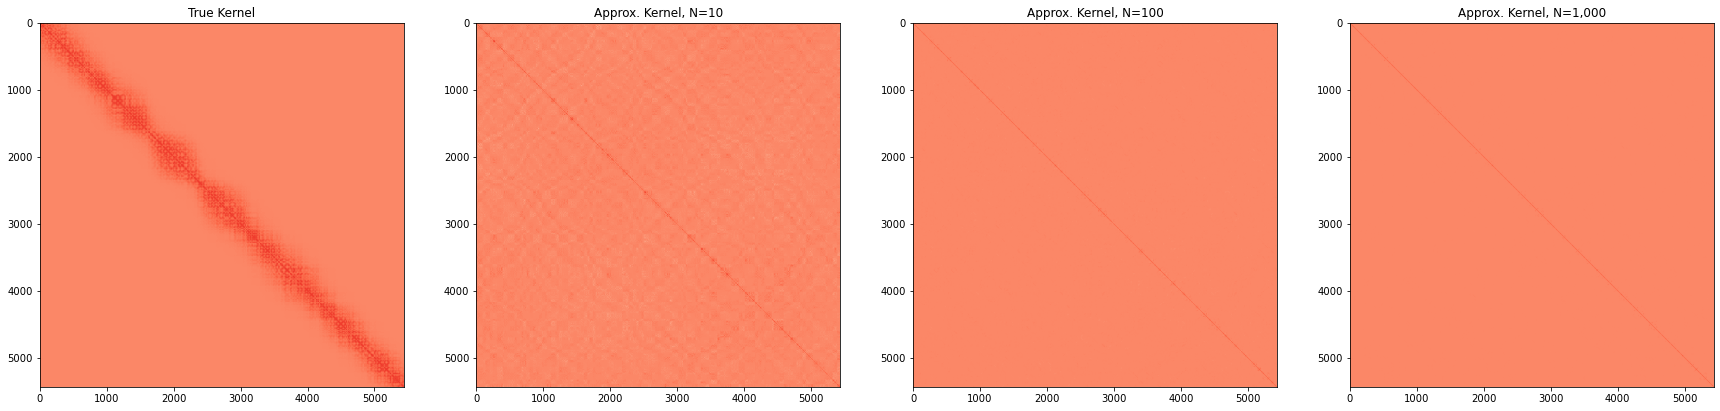

In [49]:
%time

fig, ax = plt.subplots(figsize=(30, 10), ncols=4)

# True Kernel
ax[0].imshow(K, cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[0].set(title="True Kernel")

ax[1].imshow(K_approx["10"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[1].set(title=f"Approx. Kernel, N={10}")

ax[2].imshow(K_approx["100"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[2].set(title=f"Approx. Kernel, N=100")

ax[3].imshow(K_approx["1000"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[3].set(title=f"Approx. Kernel, N=1,000")

plt.show()

In [50]:
from sklearn.kernel_approximation import Nystroem

In [51]:
%time

K_approx = {}

for i in [10, 100, 1_000]:
    
    Zt_approx = Nystroem(kernel="rbf", gamma=1/Lt**2, n_components=i).fit_transform(obs_coords[:, 0][:, None])
    Zx_approx = Nystroem(kernel="rbf", gamma=1/Lx**2, n_components=i).fit_transform(obs_coords[:, 1:])
    # K_approx[f"{i}"] = Z_approx @ Z_approx.T
    
    # Zx_approx = Nystroem(kernel="rbf", gamma=1/Lx**2, n_components=i).fit_transform(obs_coords[:, 1:])
    
    
    # K_approx[f"{i}"] = (Zx_approx @ Zx_approx.T) * (Zt_approx @ Zt_approx.T)
    
    K_approx[f"{i}"] = (Zx_approx * Zt_approx) @ (Zx_approx * Zt_approx).T
    
    # np.testing.assert_array_almost_equal(K_, K_approx[f"{i}"])
    

    
    vmin = np.minimum(vmin, K_approx[f"{i}"].min())
    vmax = np.maximum(vmax, K_approx[f"{i}"].max())

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


CPU times: user 3 µs, sys: 12 µs, total: 15 µs
Wall time: 4.05 µs


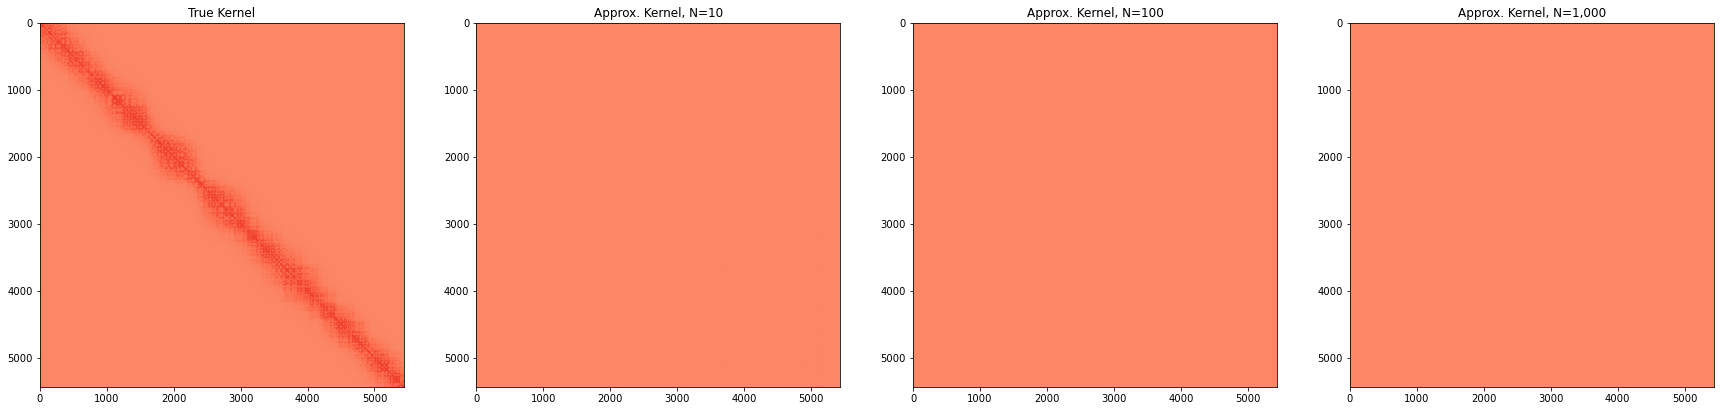

In [52]:
%time

fig, ax = plt.subplots(figsize=(30, 10), ncols=4)

# True Kernel
ax[0].imshow(K, cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[0].set(title="True Kernel")

ax[1].imshow(K_approx["10"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[1].set(title=f"Approx. Kernel, N={10}")

ax[2].imshow(K_approx["100"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[2].set(title=f"Approx. Kernel, N=100")

ax[3].imshow(K_approx["1000"], cmap="Reds", aspect="equal", vmin=vmin, vmax=vmax)
ax[3].set(title=f"Approx. Kernel, N=1,000")

plt.show()

#### Weights

**Solving**

$$
\boldsymbol{\alpha} = (\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \mathbf{y}
$$

We can use the cholesky decomposition.

$$
\begin{aligned}
\mathbf{L} &= \text{cholesky}(\mathbf{Z}^\top \mathbf{Z} + \sigma^2 \mathbf{I}) \\
\mathbf{L} \boldsymbol{\alpha} &= \mathbf{Z}^\top \mathbf{y}
\end{aligned}
$$

In [53]:
from kernellib.utils import cholesky_solve
from kernellib.krr import KRR

In [60]:
import numpy as np
from   scipy.spatial.distance import pdist, cdist, squareform
from   scipy.linalg import cholesky, cho_solve


In [61]:

class RFFGaussianProcessRegressor:

    def __init__(self, rff_dim=10, sigma=1.0):
        """Gaussian process regression using random Fourier features.
        rff_dim : Dimension of random feature.
        sigma :   sigma^2 is the variance.
        """
        self.rff_dim = rff_dim
        self.sigma   = sigma
        self.alpha_  = None
        self.b_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
        # NB: We could find alpha using a linear model. However, we could not
        #     compute the covariance matrix in that case.

        # Build kernel approximation using RFFs.
        N, _    = X.shape
        Z, W, b = self._get_rffs(X, return_vars=True)
        sigma_I = self.sigma * np.eye(N)
        self.kernel_ = Z.T @ Z + sigma_I

        # Solve for Rasmussen and William's alpha.
        lower = True
        L = cholesky(self.kernel_, lower=lower)
        self.alpha_ = cho_solve((L, lower), y)

        # Save for `predict` function.
        self.Z_train_ = Z
        self.L_ = L
        self.b_ = b
        self.W_ = W

        return self

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if self.alpha_ is None or self.b_ is None or self.W_ is None:
            msg = "This instance is not fitted yet. Call 'fit' with "\
                  "appropriate arguments before using this method."
            raise NotFit

        Z_test = self._get_rffs(X, return_vars=False)
        K_star = Z_test.T @ self.Z_train_
        y_mean = K_star.dot(self.alpha_)

        lower = True
        v = cho_solve((self.L_, lower), K_star.T)
        y_cov = (Z_test.T @ Z_test) - K_star.dot(v)

        return y_mean, y_cov

    def _get_rffs(self, X, return_vars):
        """Return random Fourier features based on data X, as well as random
        variables W and b.
        """
        N, D = X.shape
        if self.W_ is not None:
            W, b = self.W_, self.b_
        else:
            W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
            b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)

        B    = np.repeat(b[:, np.newaxis], N, axis=1)
        norm = 1./ np.sqrt(self.rff_dim)
        Z    = norm * np.sqrt(2) * np.cos(self.sigma * W @ X.T + B)
        if return_vars:
            return Z, W, b
        return Z

    def _get_rvs(self, D):
        """On first call, return random variables W and b. Else, return cached
        values.
        """
        if self.W_ is not None:
            return self.W_, self.b_
        W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
        b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)
        return W, b

In [ ]:
class RFFGaussianProcessRegressor:

    def __init__(self, kernel_approx, n_components=10):
        """Gaussian process regression using random Fourier features.
        rff_dim : Dimension of random feature.
        sigma :   sigma^2 is the variance.
        """
        self.rff_dim = rff_dim
        self.sigma   = sigma
        self.alpha_  = None
        self.b_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
        # NB: We could find alpha using a linear model. However, we could not
        #     compute the covariance matrix in that case.

        # Build kernel approximation using RFFs.
        N, _    = X.shape
        Z, W, b = self._get_rffs(X, return_vars=True)
        sigma_I = self.sigma * np.eye(N)
        self.kernel_ = Z.T @ Z + sigma_I

        # Solve for Rasmussen and William's alpha.
        lower = True
        L = cholesky(self.kernel_, lower=lower)
        self.alpha_ = cho_solve((L, lower), y)

        # Save for `predict` function.
        self.Z_train_ = Z
        self.L_ = L
        self.b_ = b
        self.W_ = W

        return self

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if self.alpha_ is None or self.b_ is None or self.W_ is None:
            msg = "This instance is not fitted yet. Call 'fit' with "\
                  "appropriate arguments before using this method."
            raise NotFit

        Z_test = self._get_rffs(X, return_vars=False)
        K_star = Z_test.T @ self.Z_train_
        y_mean = K_star.dot(self.alpha_)

        lower = True
        v = cho_solve((self.L_, lower), K_star.T)
        y_cov = (Z_test.T @ Z_test) - K_star.dot(v)

        return y_mean, y_cov

    def _get_rffs(self, X, return_vars):
        """Return random Fourier features based on data X, as well as random
        variables W and b.
        """
        N, D = X.shape
        if self.W_ is not None:
            W, b = self.W_, self.b_
        else:
            W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
            b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)

        B    = np.repeat(b[:, np.newaxis], N, axis=1)
        norm = 1./ np.sqrt(self.rff_dim)
        Z    = norm * np.sqrt(2) * np.cos(self.sigma * W @ X.T + B)
        if return_vars:
            return Z, W, b
        return Z

    def _get_rvs(self, D):
        """On first call, return random variables W and b. Else, return cached
        values.
        """
        if self.W_ is not None:
            return self.W_, self.b_
        W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
        b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)
        return W, b

In [ ]:
N, _    = X.shape

# Build kernel approximation using RFFs.

kernel = RBFSampler(gamma=Lt)
Z = kernel.fit_transform(state_coords)

sigma_I = noise * np.eye(N)
self.kernel_ = Z.T @ Z + sigma_I

# Solve for Rasmussen and William's alpha.
lower = True
L = cholesky(self.kernel_, lower=lower)
self.alpha_ = cho_solve((L, lower), y)

# Save for `predict` function.
self.Z_train_ = Z

In [72]:
rff_model = RFFGaussianProcessRegressor(rff_dim=100, sigma=10.0)

rff_model.fit(obs_coords, obs_data.data)

In [73]:
y_mu, y_cov = rff_model.predict(state_coords)

In [74]:
y_mu.shape, y_cov.shape
y_var = np.diag(y_cov)
y_std = np.sqrt(y_var)

In [54]:
cholesky_solve??

Signature: cholesky_solve(K, y)
Docstring: <no docstring>
Source:   
def cholesky_solve(K, y):
    L = cho_factor(K, lower=True)
    return cho_solve(L, y), L
File:      ~/code_projects/filterjax/notebooks/OI/kernellib/utils.py
Type:      function


In [55]:
n_components = 1_000
seed = 123
spatial_kernel_approx = Nystroem(kernel="rbf", gamma=None, n_components=n_components, random_state=seed)
temporal_kernel_approx = Nystroem(kernel="rbf", gamma=None, n_components=n_components, random_state=seed)
                                 
Zt_approx = temporal_kernel_approx.fit_transform(obs_coords[:, 0][:, None])
Zx_approx = spatial_kernel_approx.fit_transform(obs_coords[:, 1:])

Z = Zt_approx * Zx_approx
ZTZ = Z.T @ Z
ZTZ += noise ** 2 * np.eye(ZTZ.shape[0])

In [56]:
weights, L = cholesky_solve(ZTZ, Z.T @ obs_data.data) 

In [57]:
Z_trans = spatial_kernel_approx.transform(state_coords[:, 1:]) * temporal_kernel_approx.transform(state_coords[:, 0][:, None])

y_mu = Z_trans @ weights
y_mu.shape, state_coords.shape

((2652,), (2652, 3))

In [58]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

In [59]:
y_mu.shape, state_data.lon.shape

((2652,), (2652,))

##

In [246]:
from sklearn.base import BaseEstimator, RegressorMixin

class RFF:
    def __init__(self, n_components: int=10, length_scale: float=1.0):
        self.length_scale = length_scale
        self.n_components = n_components
        
    def fit(self, X):
        
        # set the random seed
        rng = np.random.RandomState(None)
    
        # create omega
        self.omega = rng.normal(size=(self.n_components, X.shape[1]))
        
        self.omega /= self.length_scale #np.sqrt(length_scale**2 / self.n_components)

        # create phi
        self.phi = rng.uniform(low=0.0, high=2 * np.pi, size=(self.n_components, 1))
        
        return self
    
    def transform(self, X):
        
        # create features
        features = np.einsum("fd, nd -> fn", self.omega, X)
        features = np.cos(features + self.phi).T
        
        return features
    
    
class RFFKRR(RegressorMixin, BaseEstimator):
    def __init__(self, kernel, alpha: float=0.01):
        self.alpha = alpha
        self.kernel = kernel
        
    def fit(self, X, y):
        
        # fit kernel
        self.kernel.fit(X)
        
        # apply kernel to data
        features = self.kernel.transform(X)
        
        # solve method
        K = np.eye(features.shape[1]) +  features.T @ features * self.alpha ** -2
        weights, L = cholesky_solve(K, features.T @ y)
        
        self.K_ = K
        self.weights_ = weights
        self.L_ = L
        
        return self
    
    def predict(self, X, return_var: bool=False):
        
        # predictive mean
        Z_trans = self.kernel.transform(X)
        y_mu = self.alpha ** -2 * Z_trans @ self.weights_
        
        # predictive covariance
        if return_var:
            v, _ = cholesky_solve(self.K_, Z_trans.T)
            y_var = np.einsum("nf, fn -> n", Z_trans, v)
        
            return y_mu, y_var
        else:
            return y_mu

In [264]:
rff_kernel = RFF(1_000, 10.0)
rff_kernel = RBFSampler(n_components=1_000, gamma=1.0)#1/Lx**2)
rff_kernel.fit(obs_coords)

features = rff_kernel.transform(obs_coords)
features.shape

(5436, 1000)

In [265]:
rff_model = RFFKRR(kernel=rff_kernel, alpha=0.1)

rff_model.fit(obs_coords, obs_data.data)

y_mu, y_var = rff_model.predict(state_coords, True)
print(y_mu.shape, y_var.shape)
y_std = np.sqrt(y_var)

(2652,) (2652,)


In [266]:
rff_model.get_params()

{'alpha': 0.1,
 'kernel__gamma': 1.0,
 'kernel__n_components': 1000,
 'kernel__random_state': None,
 'kernel': RBFSampler(n_components=1000)}

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


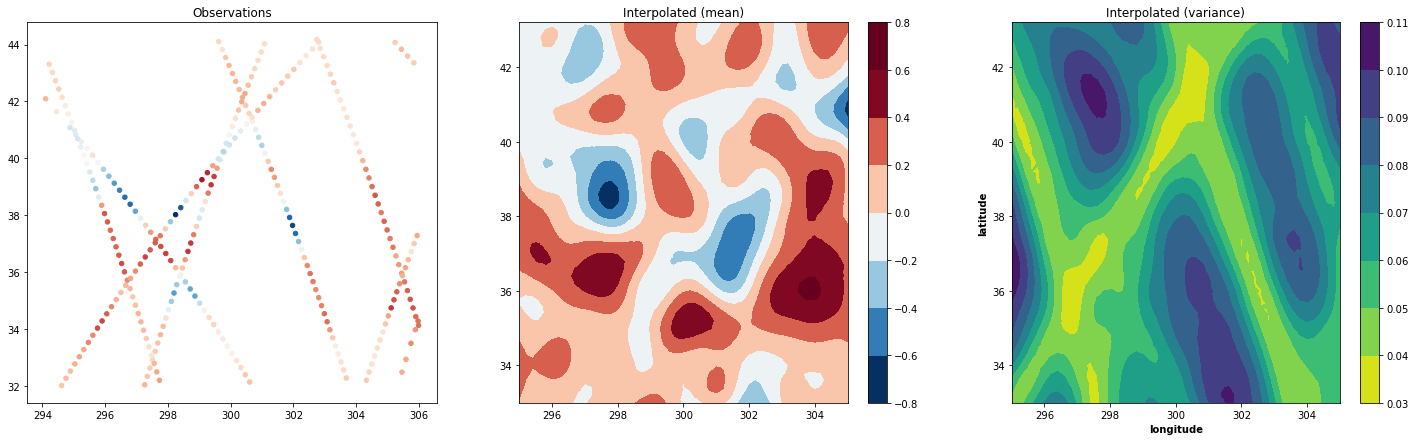

In [267]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

In [268]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats.distributions import uniform

param_distributions = {
    "alpha": loguniform(1e-3, 1e1),
    "kernel__gamma": loguniform(0.1, 100.0),
}
kernel_ridge_tuned = RandomizedSearchCV(
    rff_model,
    param_distributions=param_distributions,
    n_iter=100,
    random_state=0,
    verbose=1
)

kernel_ridge_tuned.fit(obs_coords, obs_data.data)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 7min 2s, sys: 3min 20s, total: 10min 23s
Wall time: 1min 39s


RandomizedSearchCV(estimator=RFFKRR(alpha=0.1,
                                    kernel=RBFSampler(n_components=1000)),
                   n_iter=100,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1883f7be0>,
                                        'kernel__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x19ae8a970>},
                   random_state=0, verbose=1)

In [269]:
kernel_ridge_tuned.best_params_

{'alpha': 2.0689982192171272, 'kernel__gamma': 0.10329669551879735}

In [270]:
y_mu, y_var = kernel_ridge_tuned.best_estimator_.predict(state_coords, return_var=True)
y_std = np.sqrt(y_var)

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


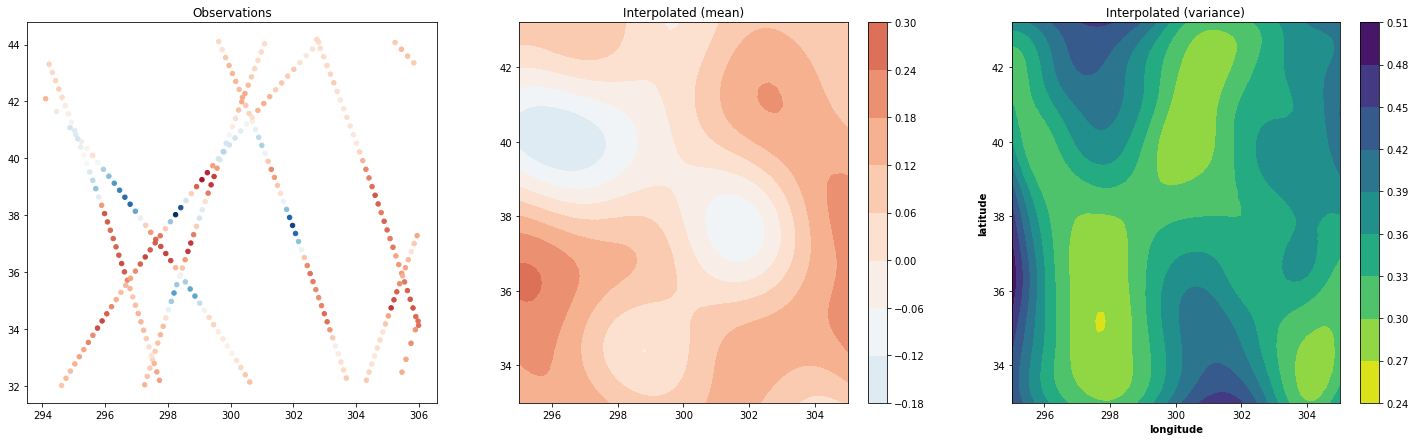

In [271]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


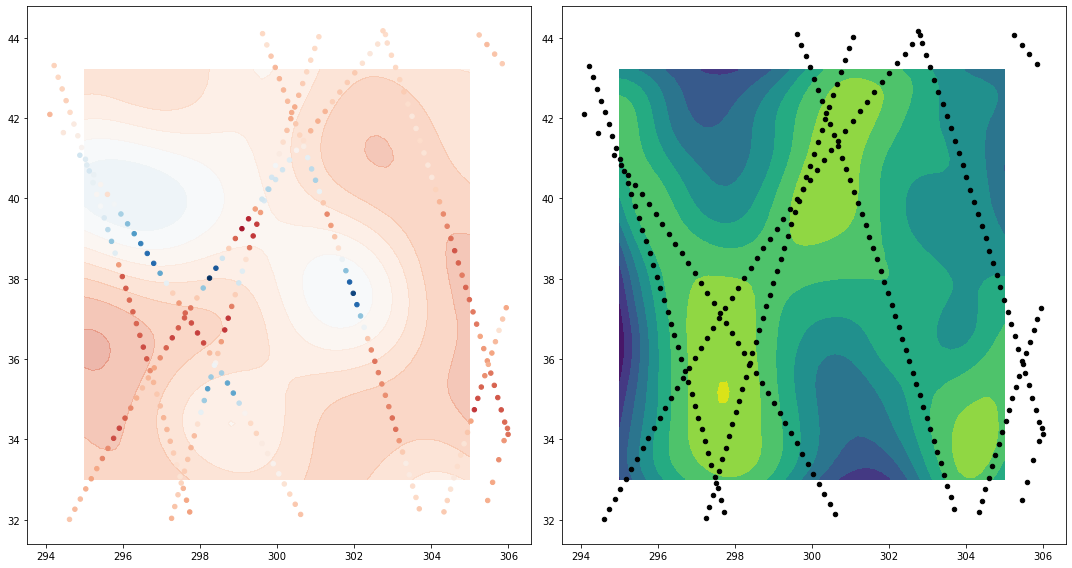

In [272]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

In [230]:
from scipy.linalg import solve_triangular

In [ ]:
solve_triangular

In [197]:
def rff_eq(
    x: np.ndarray, 
    n_components: int=10,
    seed: int=123, 
    return_params: bool=False,
    length_scale: float=1.0,
):
    
    # set the random seed
    rng = np.random.RandomState(seed)
    
    # create omega
    shape = (n_components, x.shape[1])
    omega = (length_scale**2 / n_components) * rng.normal(size=shape)
    
    # omega /= length_scale
    

    
    # create weights
    weights = rng.normal(loc=0.0, scale=1.0, size=(n_components))

    # create phi
    phi = rng.uniform(low=0.0, high=2 * np.pi, size=(n_components, 1))

    # create features
    rff_eq_kernel
    
    params

    return features

def rff_eq_kernel(x, phi, omega):
    # create features
    features = np.einsum("fd, nd -> fn", omega, x)
    features = np.cos(features + phi).T
    
    return features


def rff_posterior(features, y_data, x_pred, fn):
    
    iS = np.eye(features.shape[1]) + features.T @ features
    
    
    weights, L = cholesky_solve(iS, features.T @ y_data)
    
    
    
    return None

In [198]:
features, fn = rff_eq(obs_coords, 1_000, None, False, 1.0)
features.shape, obs_coords.shape

NameError: name 'params' is not defined

In [125]:
rff_posterior(features, obs_data.data, None)

(1000,) (1000, 1000)


In [199]:
def sample_rff(x, kernel, lengthscale, coefficient, num_functions, num_features):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale -- same operation for all three kernels
    omega *= (length_scale**2 / n_components)
    
    weights = np.random.normal(loc=0.,
                               scale=1.,
                               size=(num_functions, num_features))
    
    phi = np.random.uniform(low=0.,
                            high=(2 * np.pi),
                            size=(num_functions, num_features, 1))
    
    features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = np.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

In [200]:
functions, features = sample_rff(state_coords, "eq", 1.0, 1.0, num_functions=100, num_features=200)
functions.shape, features.shape

((100, 2652), (100, 200, 2652))

In [79]:
def rff_posterior(x_data, y_data, x_pred, kernel, lengthscale, coefficient, num_features, noise):
    
    num_data = x_data.shape[0]
    x_full = np.concatenate([x_pred, x_data])
    
    _, features = sample_rff(x=x_full, 
                             kernel=kernel, 
                             lengthscale=lengthscale, 
                             coefficient=coefficient, 
                             num_functions=1, 
                             num_features=num_features)
    features = features[0]
    
    features_pred = features[:, :-num_data]
    features_data = features[:, -num_data:]
    
    iS = np.eye(features_data.shape[0]) + features_data @ features_data.T * noise ** -2

    mean_pred = noise ** -2 * features_pred.T @ np.linalg.solve(iS, features_data @ y_data)[:, 0]
    
    var_pred = np.einsum('fn, fn -> n',
                         features_pred,
                         np.linalg.solve(iS, features_pred))
    
    return mean_pred, var_pred

In [82]:
y_mu, y_var = rff_posterior(obs_coords, obs_data.data[:, None], state_coords, "eq", 1.0, 1.0, 1000, noise**2)

In [84]:
y_mu.shape, y_var.shape
y_std = np.sqrt(y_var)

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_70875/2193579209.py:7: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


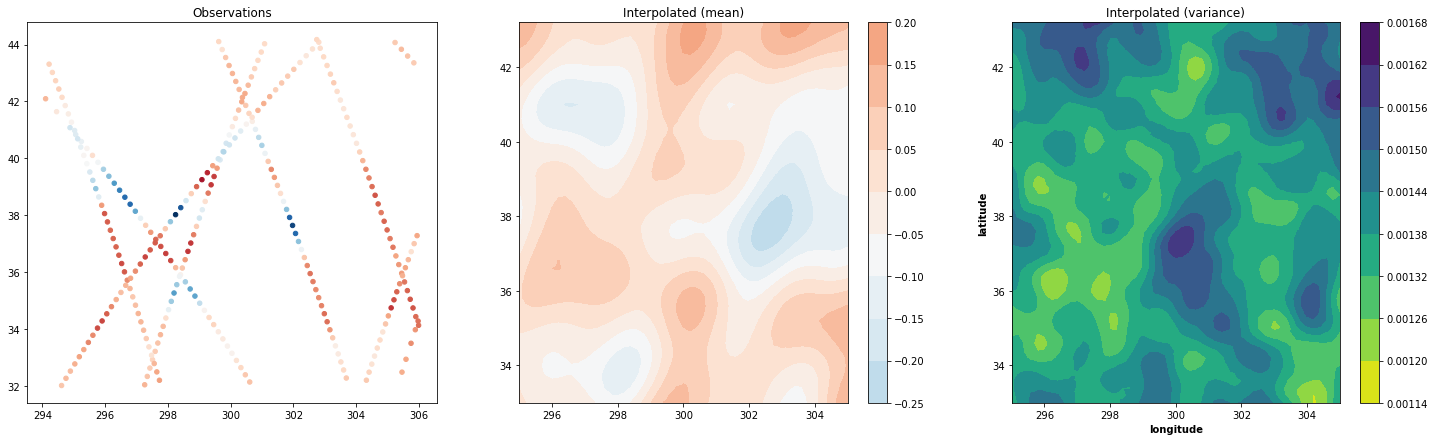

In [196]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

In [86]:
from sklearn.linear_model._ridge import _solve_cholesky_kernel
from scipy.linalg import solve_triangular
from sklearn.base import BaseEstimator, RegressorMixin

In [87]:
# class KRR(RegressorMixin, BaseEstimator):
#     def __init__(self, alpha=0.1, kernel=None):
#         self.alpha = alpha
#         self.kernel = kernel
        
    
#     def fit(self, X, y):
        
#         # create kernel matrix (data)
#         K = self.kernel(X)
        
#         # add the noise to diagonal elements
#         np.fill_diagonal(K, K.diagonal() + alpha)
        
#         # find the weights, alpha = (K + noise)^-1 y
#         weights, L = cholesky_solve(K, y)
        
#         self.weights_ = weights
#         self.L_ = L
#         self.X_fit_ = X
        
#         return self
    
#     def predict(self, X, return_var: bool=False, return_cov: bool=False):
#         # TODO include noise
        
#         # make predictions
#         K_trans = self.kernel(X, self.X_fit_)

#         # predictive mean
#         y_pred = np.dot(K_trans, weights)


#         if return_var:
#             # TODO Fix this to the kernel

#             # diagonal elements
#             y_var = np.ones(K_trans.shape[0])

#             # solve
#             v = solve_triangular(self.L_[0], K_trans.T, lower=True)
#             y_var = y_var + np.einsum("ij,ji->i", v.T, v)

#             return y_pred, y_var

#         elif return_cov:

#             K_star = self.kernel(X, X)
#             v = solve_triangular(self.L_[0], K_trans.T, lower=True)
#             y_cov = K_star - v.T @ v

#             return y_pred, y_cov
#         else:

#             return y_pred
    
#     def sample(self, X: np.ndarray=None, n_samples: int=1, seed: int=123):
        
#         rng = np.random.RandomState(seed)
        
#         # predictions
#         if X is None:
#             X = self.X_fit_
        
#         # make predictions (mean, cov)
#         y_mu, y_cov = self.predict(X=X, return_cov=True)
        
#         # sample from a Gaussian distribution
#         y_samples = rng.multivariate_normal(y_mu.squeeze(), y_cov, n_samples).T
        
#         return y_samples


In [88]:
# noise (regularization) model
alpha = noise ** 2

# kernel matrix


# create model
krr_model = KRR(alpha=alpha, kernel=kernel)

In [89]:
# training data
y = obs_data.data[:, None]
x = obs_coords

# fit model
krr_model.fit(x, y)

KRR(alpha=0.0025000000000000005,
    kernel=RBF(length_scale=1) * RBF(length_scale=1))

In [90]:
%%time

y_mu, y_var = krr_model.predict(state_coords, return_var=True)
_, y_cov = krr_model.predict(state_coords, return_cov=True)

y_std = np.sqrt(y_var)

CPU times: user 1.22 s, sys: 225 ms, total: 1.45 s
Wall time: 347 ms


In [91]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

$$
\begin{aligned}
\boldsymbol{m}(\mathbf{x}^*) &= \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*) \boldsymbol{\alpha} \\
\boldsymbol{\sigma}^2(\mathbf{x}^*) &= \boldsymbol{k}(\mathbf{x}^*, \mathbf{x'}^*) - \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)(\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)^\top
\end{aligned}
$$

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


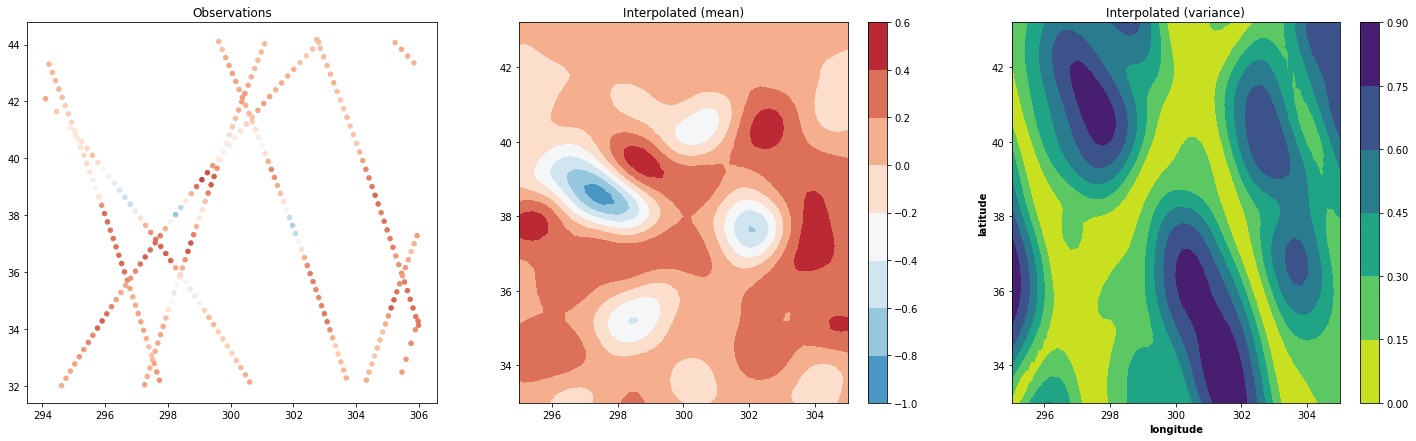

In [92]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


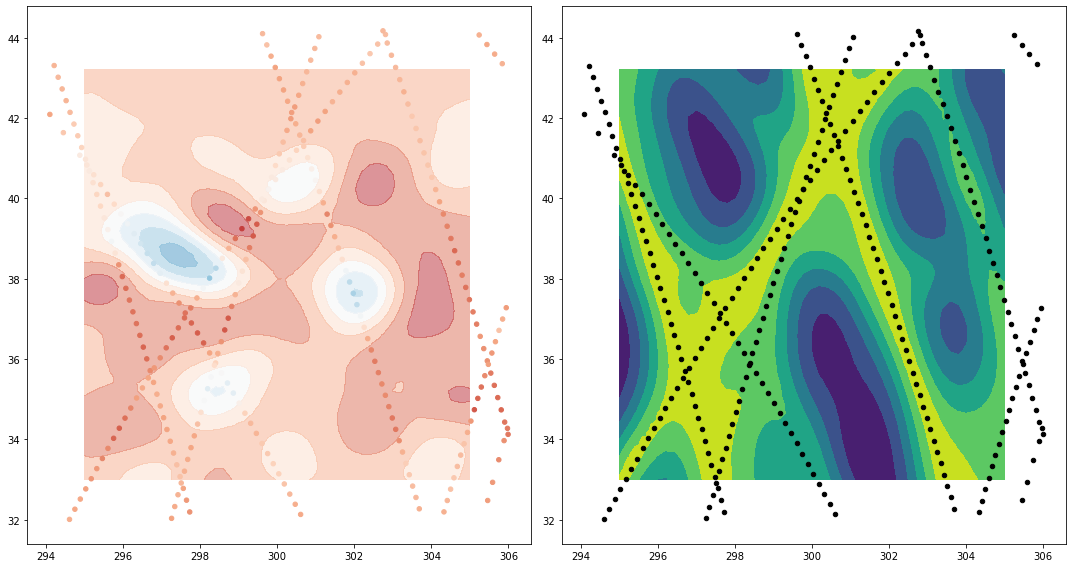

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

#### Samples

We can calculate the conditional GP posterior from the above mean and covariance equations. Then we can sample from a Normal distribution


$$
\mathbf{x}' \sim \mathcal{N}(\mathbf{x}^* | \boldsymbol{m}(\mathbf{x}^*), \boldsymbol{\Sigma}(\mathbf{x}^*, \mathbf{x'}^*)
$$

In [94]:
%%time

nrows = 10
ncols = 10
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

y_samples = krr_model.sample(state_coords, n_samples=n_samples)


CPU times: user 1min 29s, sys: 10.9 s, total: 1min 40s
Wall time: 39.3 s


In [95]:
y_mu, y_std = y_samples.mean(axis=1), y_samples.std(axis=1)

In [96]:
# vmin = y_mu.min()
# vmax = y_mu.max()
# buffer = 1.5

#### Mean

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


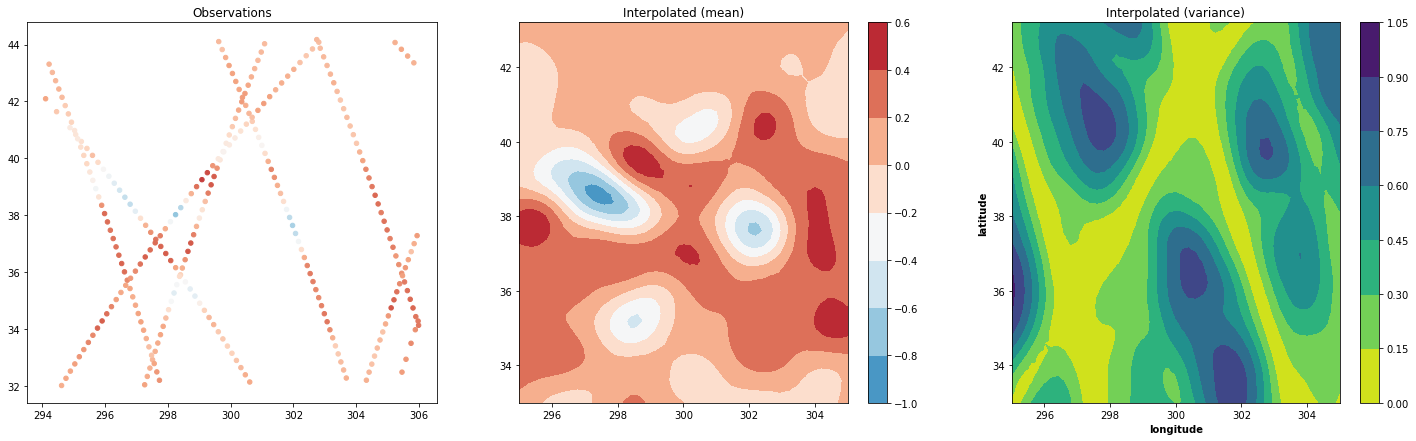

In [97]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


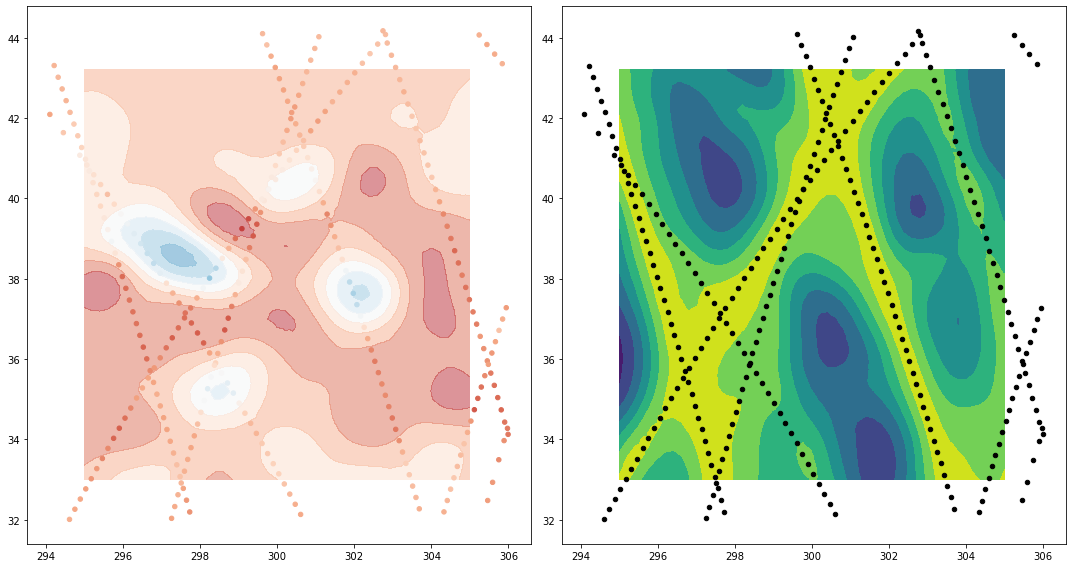

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

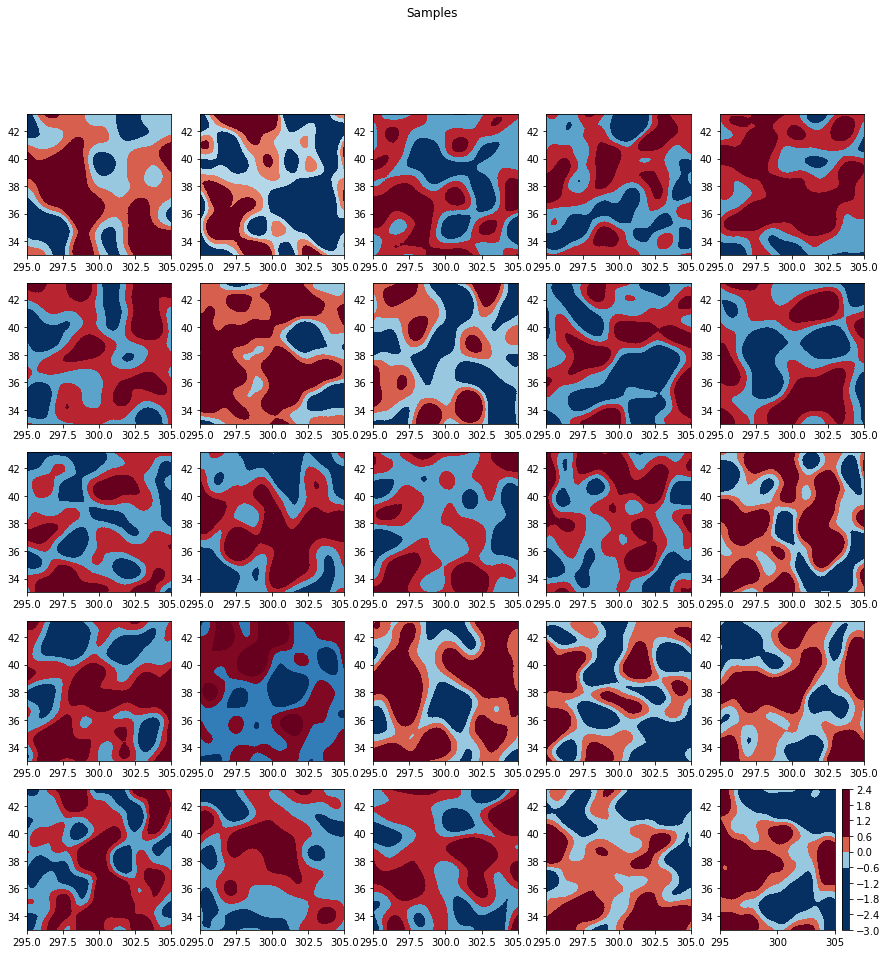

In [86]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    img = iax.tricontourf(state_data.lon, state_data.lat, functions[i, :].squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.colorbar(img)
plt.show()

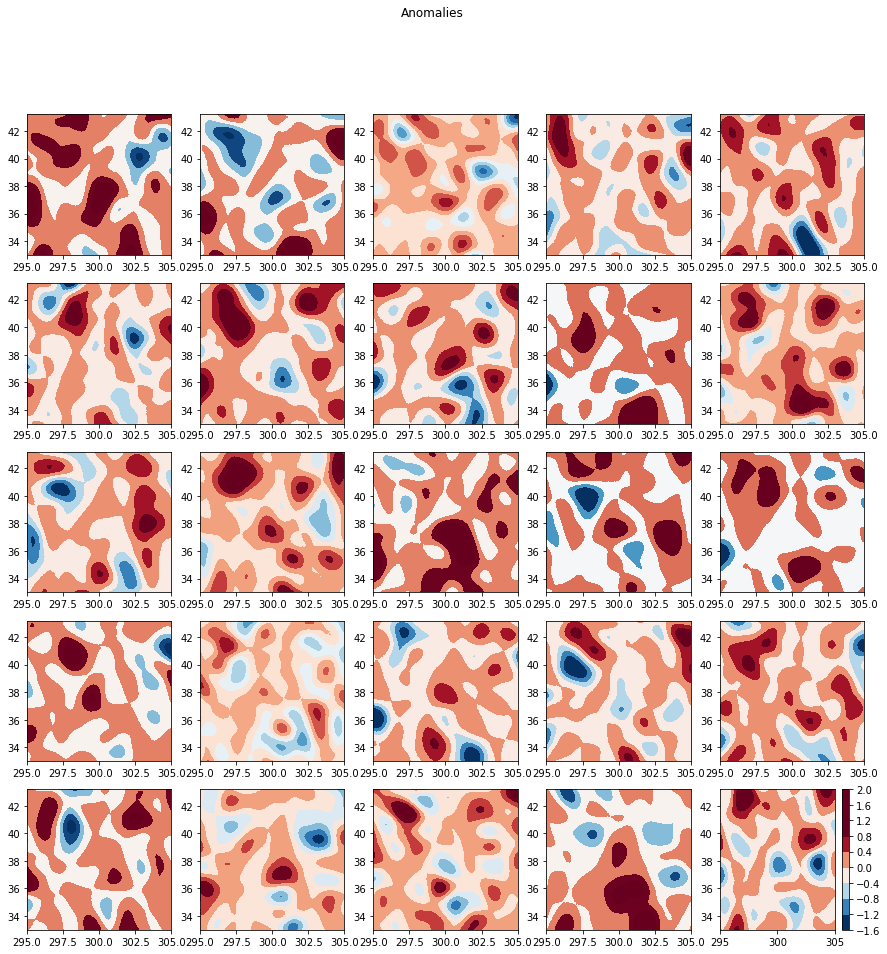

In [100]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    # anomalies
    anomaly = y_mu.squeeze() - y_samples[:, i].squeeze()
    img = iax.tricontourf(state_data.lon, state_data.lat, anomaly.squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Anomalies")
plt.colorbar(img)
plt.show()

In [101]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # DATA KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    
    krr_model.fit(obs_coords, obs_data.data)
    
    # CROSS KERNEL
    
    y_mu, y_var = krr_model.predict(state_coords, return_var=True)
    
    
    # save into data arrays
    ds_oi_grid.gssh_mu[i_time, :, :] = y_mu.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.gssh_var[i_time, :, :] = y_var.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [102]:
krr_model.kernel

RBF(length_scale=1) * RBF(length_scale=1)

In [103]:
ds_oi_grid.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [104]:
ds_oi_grid.gssh_var.hvplot.image(width=500, height=400, cmap="viridis_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_var)

### Trained

In [105]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats.distributions import uniform

param_distributions = {
    "alpha": loguniform(1e-3, 1e1),
    "kernel__k1__length_scale": loguniform(0.1, 100.0),
    "kernel__k2__length_scale": loguniform(1.0, 100.0),
}
kernel_ridge_tuned = RandomizedSearchCV(
    krr_model,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
    verbose=1
)

kernel_ridge_tuned.fit(obs_coords, obs_data.data)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: user 2min 17s, sys: 37.4 s, total: 2min 54s
Wall time: 25.8 s


RandomizedSearchCV(estimator=KRR(alpha=0.0025000000000000005,
                                 kernel=RBF(length_scale=1) * RBF(length_scale=1)),
                   n_iter=500,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x188eef700>,
                                        'kernel__k1__length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x18a360d00>,
                                        'kernel__k2__length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x188eef5b0>},
                   random_state=0, verbose=1)

In [106]:
kernel_ridge_tuned.best_params_

{'alpha': 0.2264427601216974,
 'kernel__k1__length_scale': 77.32340308192192,
 'kernel__k2__length_scale': 1.0807950494367506}

In [107]:
krr_model_trained = kernel_ridge_tuned.best_estimator_
krr_model_trained

KRR(alpha=0.2264427601216974,
    kernel=RBF(length_scale=77.3) * RBF(length_scale=1.08))

In [108]:
%%time

y_mu, y_var = krr_model_trained.predict(state_coords, return_var=True)

y_std = np.sqrt(y_var)

CPU times: user 253 ms, sys: 44.6 ms, total: 297 ms
Wall time: 45.1 ms


In [109]:
vmin = y_mu.min()
vmax = y_mu.max()
buffer = 1.5

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


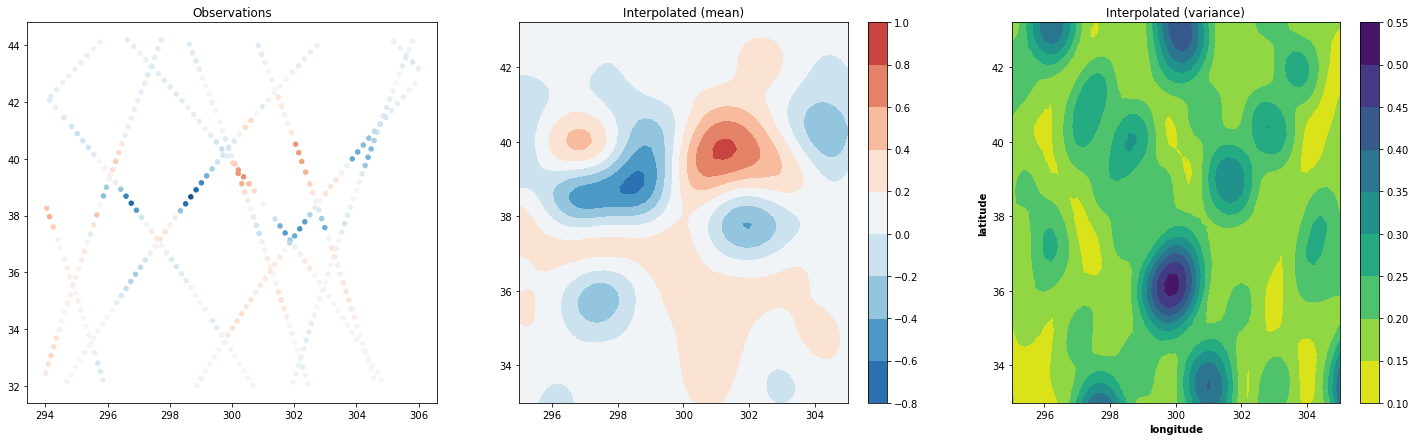

In [110]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


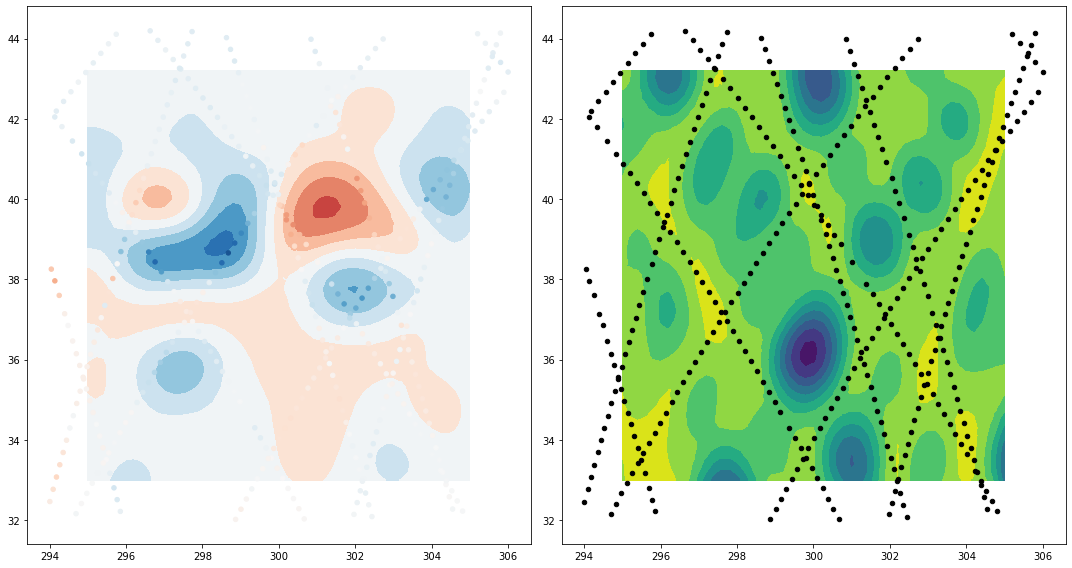

In [111]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

#### Samples

In [112]:
%%time

nrows = 10
ncols = 10
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

y_samples = krr_model_trained.sample(state_coords, n_samples=n_samples)

CPU times: user 50.8 s, sys: 9.27 s, total: 1min
Wall time: 8.79 s


In [113]:
y_mu, y_std = y_samples.mean(axis=1), y_samples.std(axis=1)

##### Mean

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3721938212.py:8: UserWarning: The following kwargs were not used by contour: 'aspect'
  img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


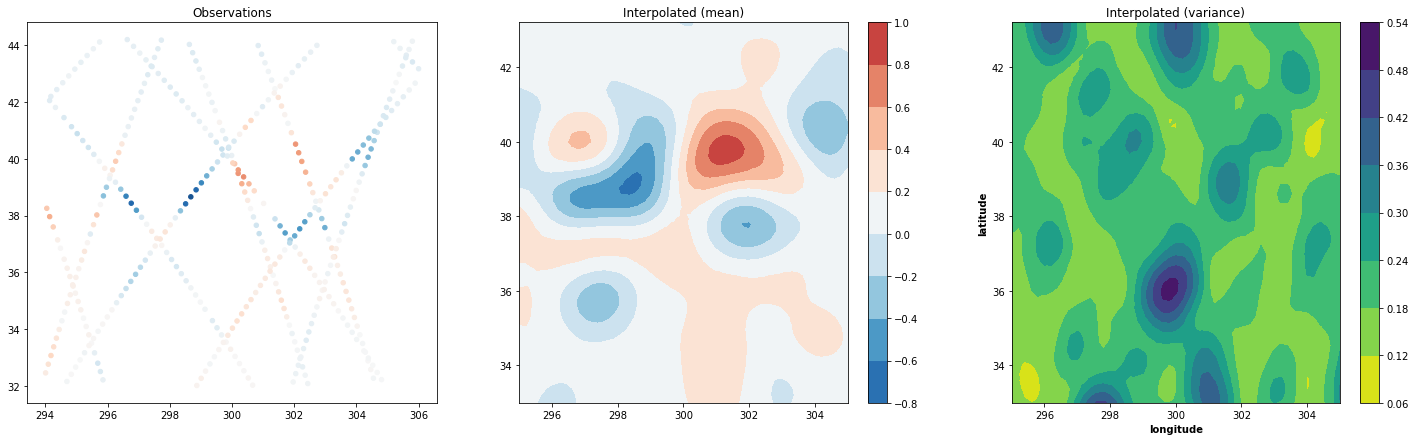

In [114]:
fig, ax = plt.subplots(figsize=(25, 7), ncols=3)


ax[0].scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)

img = ax[1].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
img = plt.colorbar(img, ax=ax[1])
img = ax[2].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
plt.colorbar(img, ax=ax[2])
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Observations')
ax[1].set(title=f'Interpolated (mean)')
ax[2].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3987732143.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


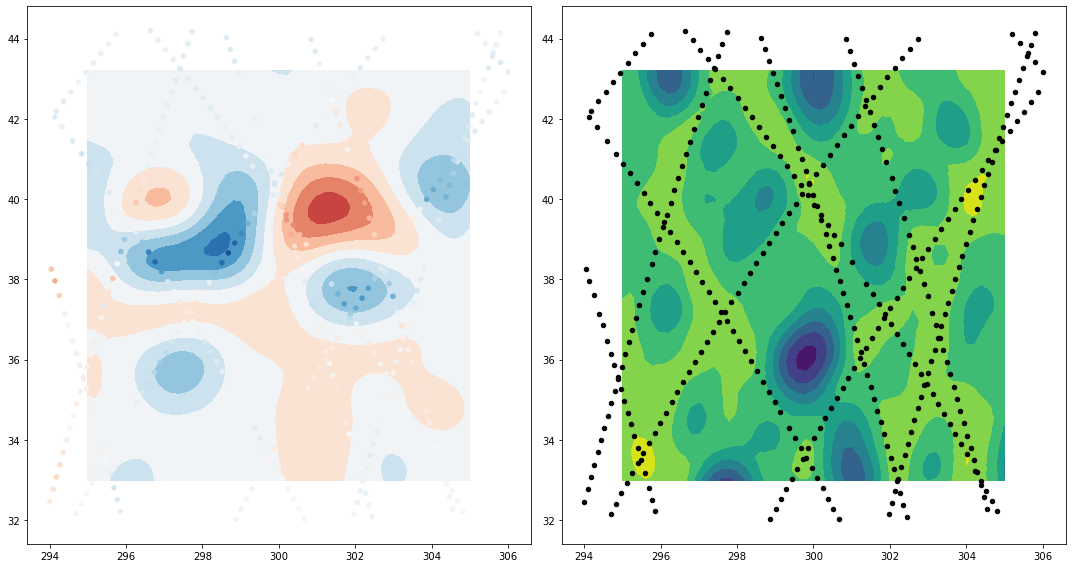

In [115]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

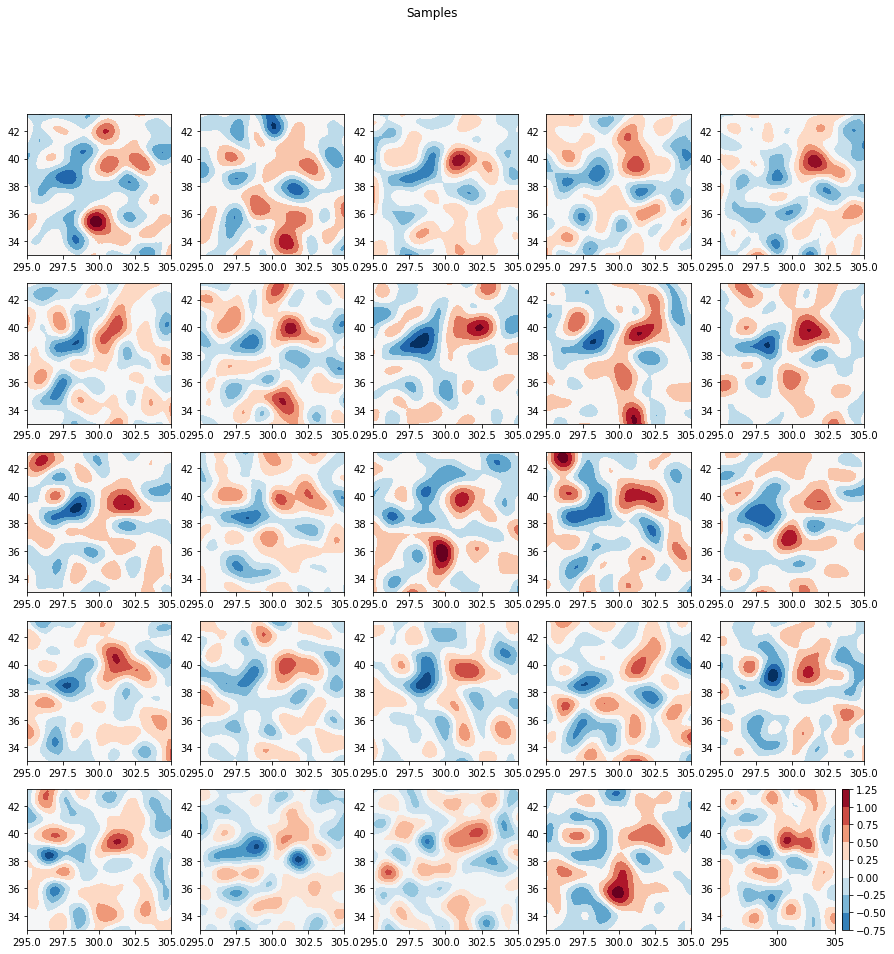

In [116]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    img = iax.tricontourf(state_data.lon, state_data.lat, y_samples[:, i].squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.colorbar(img)
plt.show()

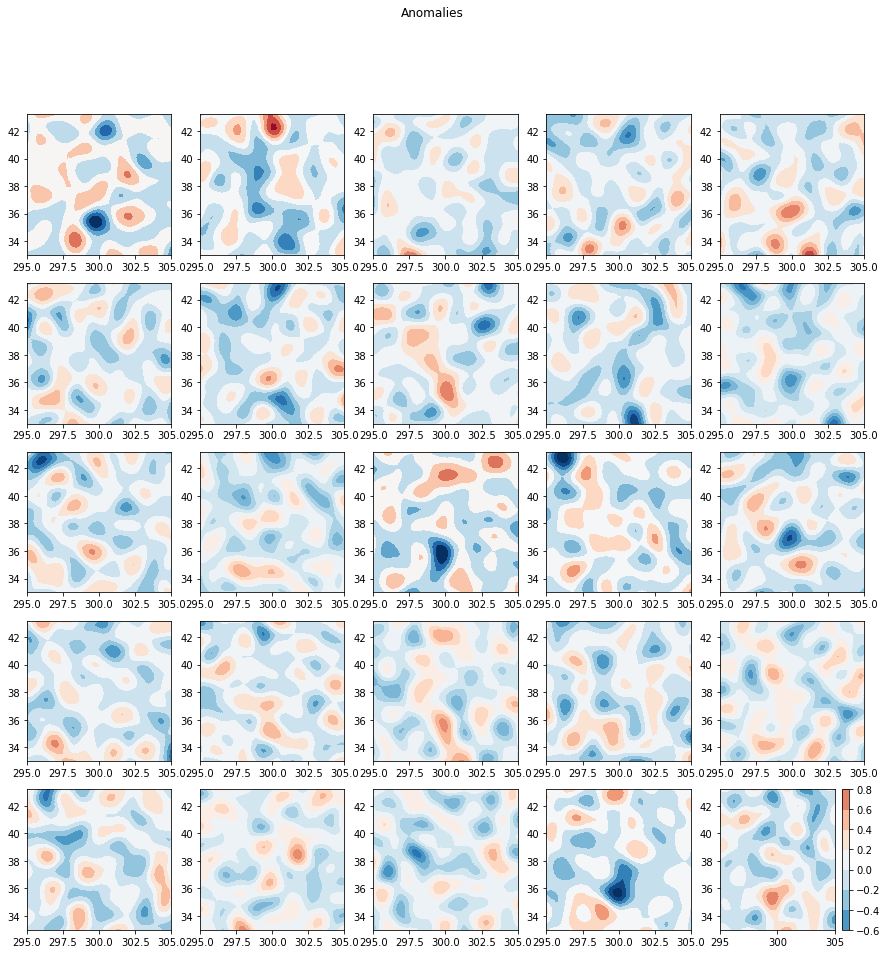

In [117]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=5, ncols=5)
n = 0
for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    # anomalies
    anomaly = y_mu.squeeze() - y_samples[:, i].squeeze()
    img = iax.tricontourf(state_data.lon, state_data.lat, anomaly.squeeze(), cmap='RdBu_r', vmin=vmin * buffer, vmax=vmax * buffer)
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Anomalies")
plt.colorbar(img)
plt.show()

In [118]:
ds_oi_grid_trained = ds_oi_grid.copy()

In [119]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # DATA KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    
    krr_model_trained.fit(obs_coords, obs_data.data)
    
    # CROSS KERNEL
    
    y_mu, y_var = krr_model_trained.predict(state_coords, return_var=True)
    
    
    # save into data arrays
    ds_oi_grid_trained.gssh_mu[i_time, :, :] = y_mu.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid_trained.gssh_var[i_time, :, :] = y_var.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid_trained.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [120]:
ds_oi_grid_trained.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [121]:
ds_oi_grid_trained.gssh_var.hvplot.image(width=500, height=400, cmap="viridis_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_var)